**UNET semantic segmentation on pascal-context dataset**

# Installing requirements

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-hxvvgt6s
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-hxvvgt6s
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import albumentations as A
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras

# Downloading Dataset

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar
!tar -xf VOCtrainval_03-May-2010.tar

--2024-08-09 22:18:56--  http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1345040896 (1.3G) [application/x-tar]
Saving to: ‘VOCtrainval_03-May-2010.tar.1’

VOCtrainval_03-May- 100%[===================>]   1.25G  22.6MB/s    in 61s     

2024-08-09 22:19:58 (21.0 MB/s) - ‘VOCtrainval_03-May-2010.tar.1’ saved [1345040896/1345040896]



In [ ]:
!wget https://cs.stanford.edu/~roozbeh/pascal-context/trainval.tar.gz
!tar -xzf trainval.tar.gz

--2024-08-09 22:20:11--  https://cs.stanford.edu/~roozbeh/pascal-context/trainval.tar.gz
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30710501 (29M) [application/x-gzip]
Saving to: ‘trainval.tar.gz.1’

trainval.tar.gz.1   100%[===================>]  29.29M  8.01MB/s    in 4.8s    

2024-08-09 22:20:17 (6.15 MB/s) - ‘trainval.tar.gz.1’ saved [30710501/30710501]



# Data loading and preprocessing

In [ ]:
IMG_HEIGHT = 160
IMG_WIDTH  = 160

In [ ]:
def read_data(path):
    labels_path = os.path.join(path,
                                "VOCdevkit/VOC2010/ImageSets/Main/",
                                "trainval.txt")
    with open(labels_path,"r") as file_:
        instances = file_.read().split()
        img_arr = []
        seg_arr = []
        for img in instances:
            img_path = os.path.join(path,
                                    "VOCdevkit/VOC2010",
                                    "JPEGImages",
                                    img+".jpg")
            seg_path = os.path.join(path,
                                    "trainval",
                                    img+".mat")

            img = np.array(Image.open(img_path)\
                           .resize((IMG_WIDTH, IMG_HEIGHT)))

            seg = scipy.io.loadmat(seg_path)['LabelMap']
            seg = cv2.resize(seg, (IMG_WIDTH, IMG_HEIGHT),
                             interpolation=cv2.INTER_NEAREST)

            img_arr.append(img)
            seg_arr.append(seg)

    return np.array(img_arr), np.array(seg_arr)

In [ ]:
path = "/content"
full_dataset = tf.data.Dataset.from_tensor_slices(read_data(path))

In [ ]:
DATASET_SIZE = 10103

In [ ]:
train_size = int(0.6 * DATASET_SIZE)
val_size = int(0.3 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

## Preprocess

In [ ]:
def normalize(input_image, input_mask):

    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask[input_mask < 0] == 431
    input_mask[input_mask > 459] == 431
    input_mask = input_mask - 1

    return input_image, input_mask

In [ ]:
def load_image_train(input_image, input_mask):

    input_mask = input_mask[ ..., np.newaxis]

    """if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)"""

    input_mask = input_mask[:, :, 0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(input_image, input_mask):

    input_mask = input_mask[np.newaxis, ...]

    input_mask = input_mask[0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = train_size // BATCH_SIZE

In [ ]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val = train_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE).repeat()

## Showing some examples of dataset

(160, 160, 3)


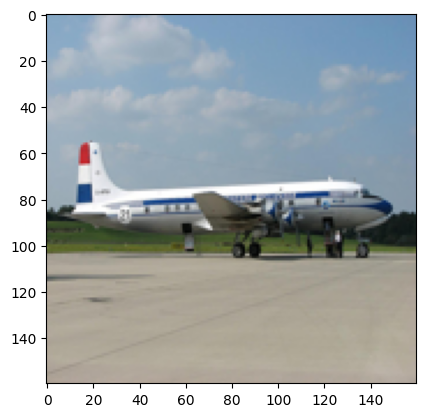

(160, 160)


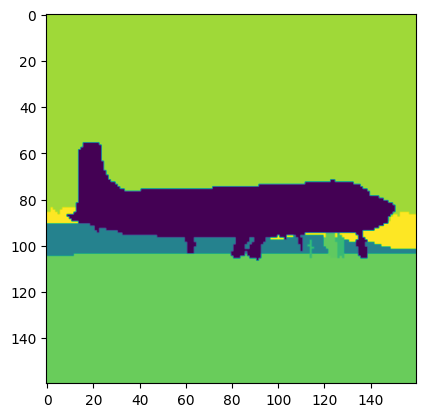

(160, 160, 3)


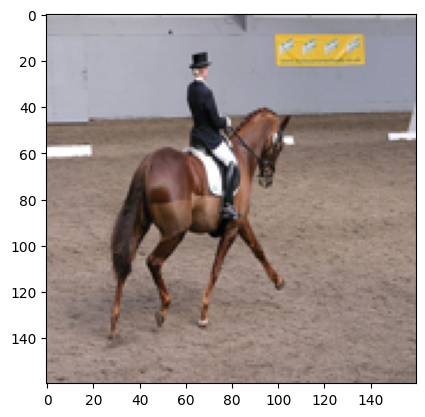

(160, 160)


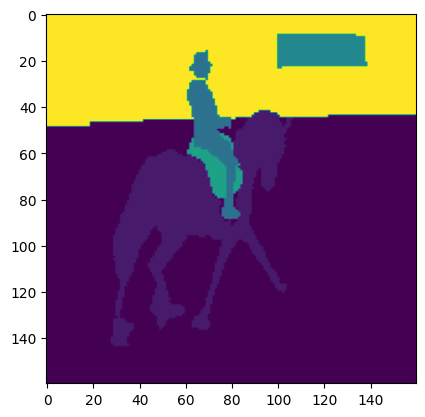

In [ ]:
for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    plt.imshow(sample_image)
    print(sample_image.shape)
    plt.show()
    plt.imshow(sample_mask)
    print(mask.shape)
    plt.show()

# UNET Model implementation

In [ ]:
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False)

# use the output of listed layers from MobileNet for U-Net Model
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# build the feature extraction model (encoder)
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
# Up stack of U-net Model
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = inputs

    # downsampling and extracting features
    skips = down_stack(x)
    x = skips[-1]

    # layers to establish skip connections in the encoder model
    skips = reversed(skips[:-1])

    # establish skip connections between layers of encoder and decoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # the last layer
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')   #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
from keras.optimizers import Adam
from keras.metrics import MeanIoU

In [ ]:
optimizer = Adam(learning_rate=1e-4)

OUTPUT_CHANNELS = 459
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

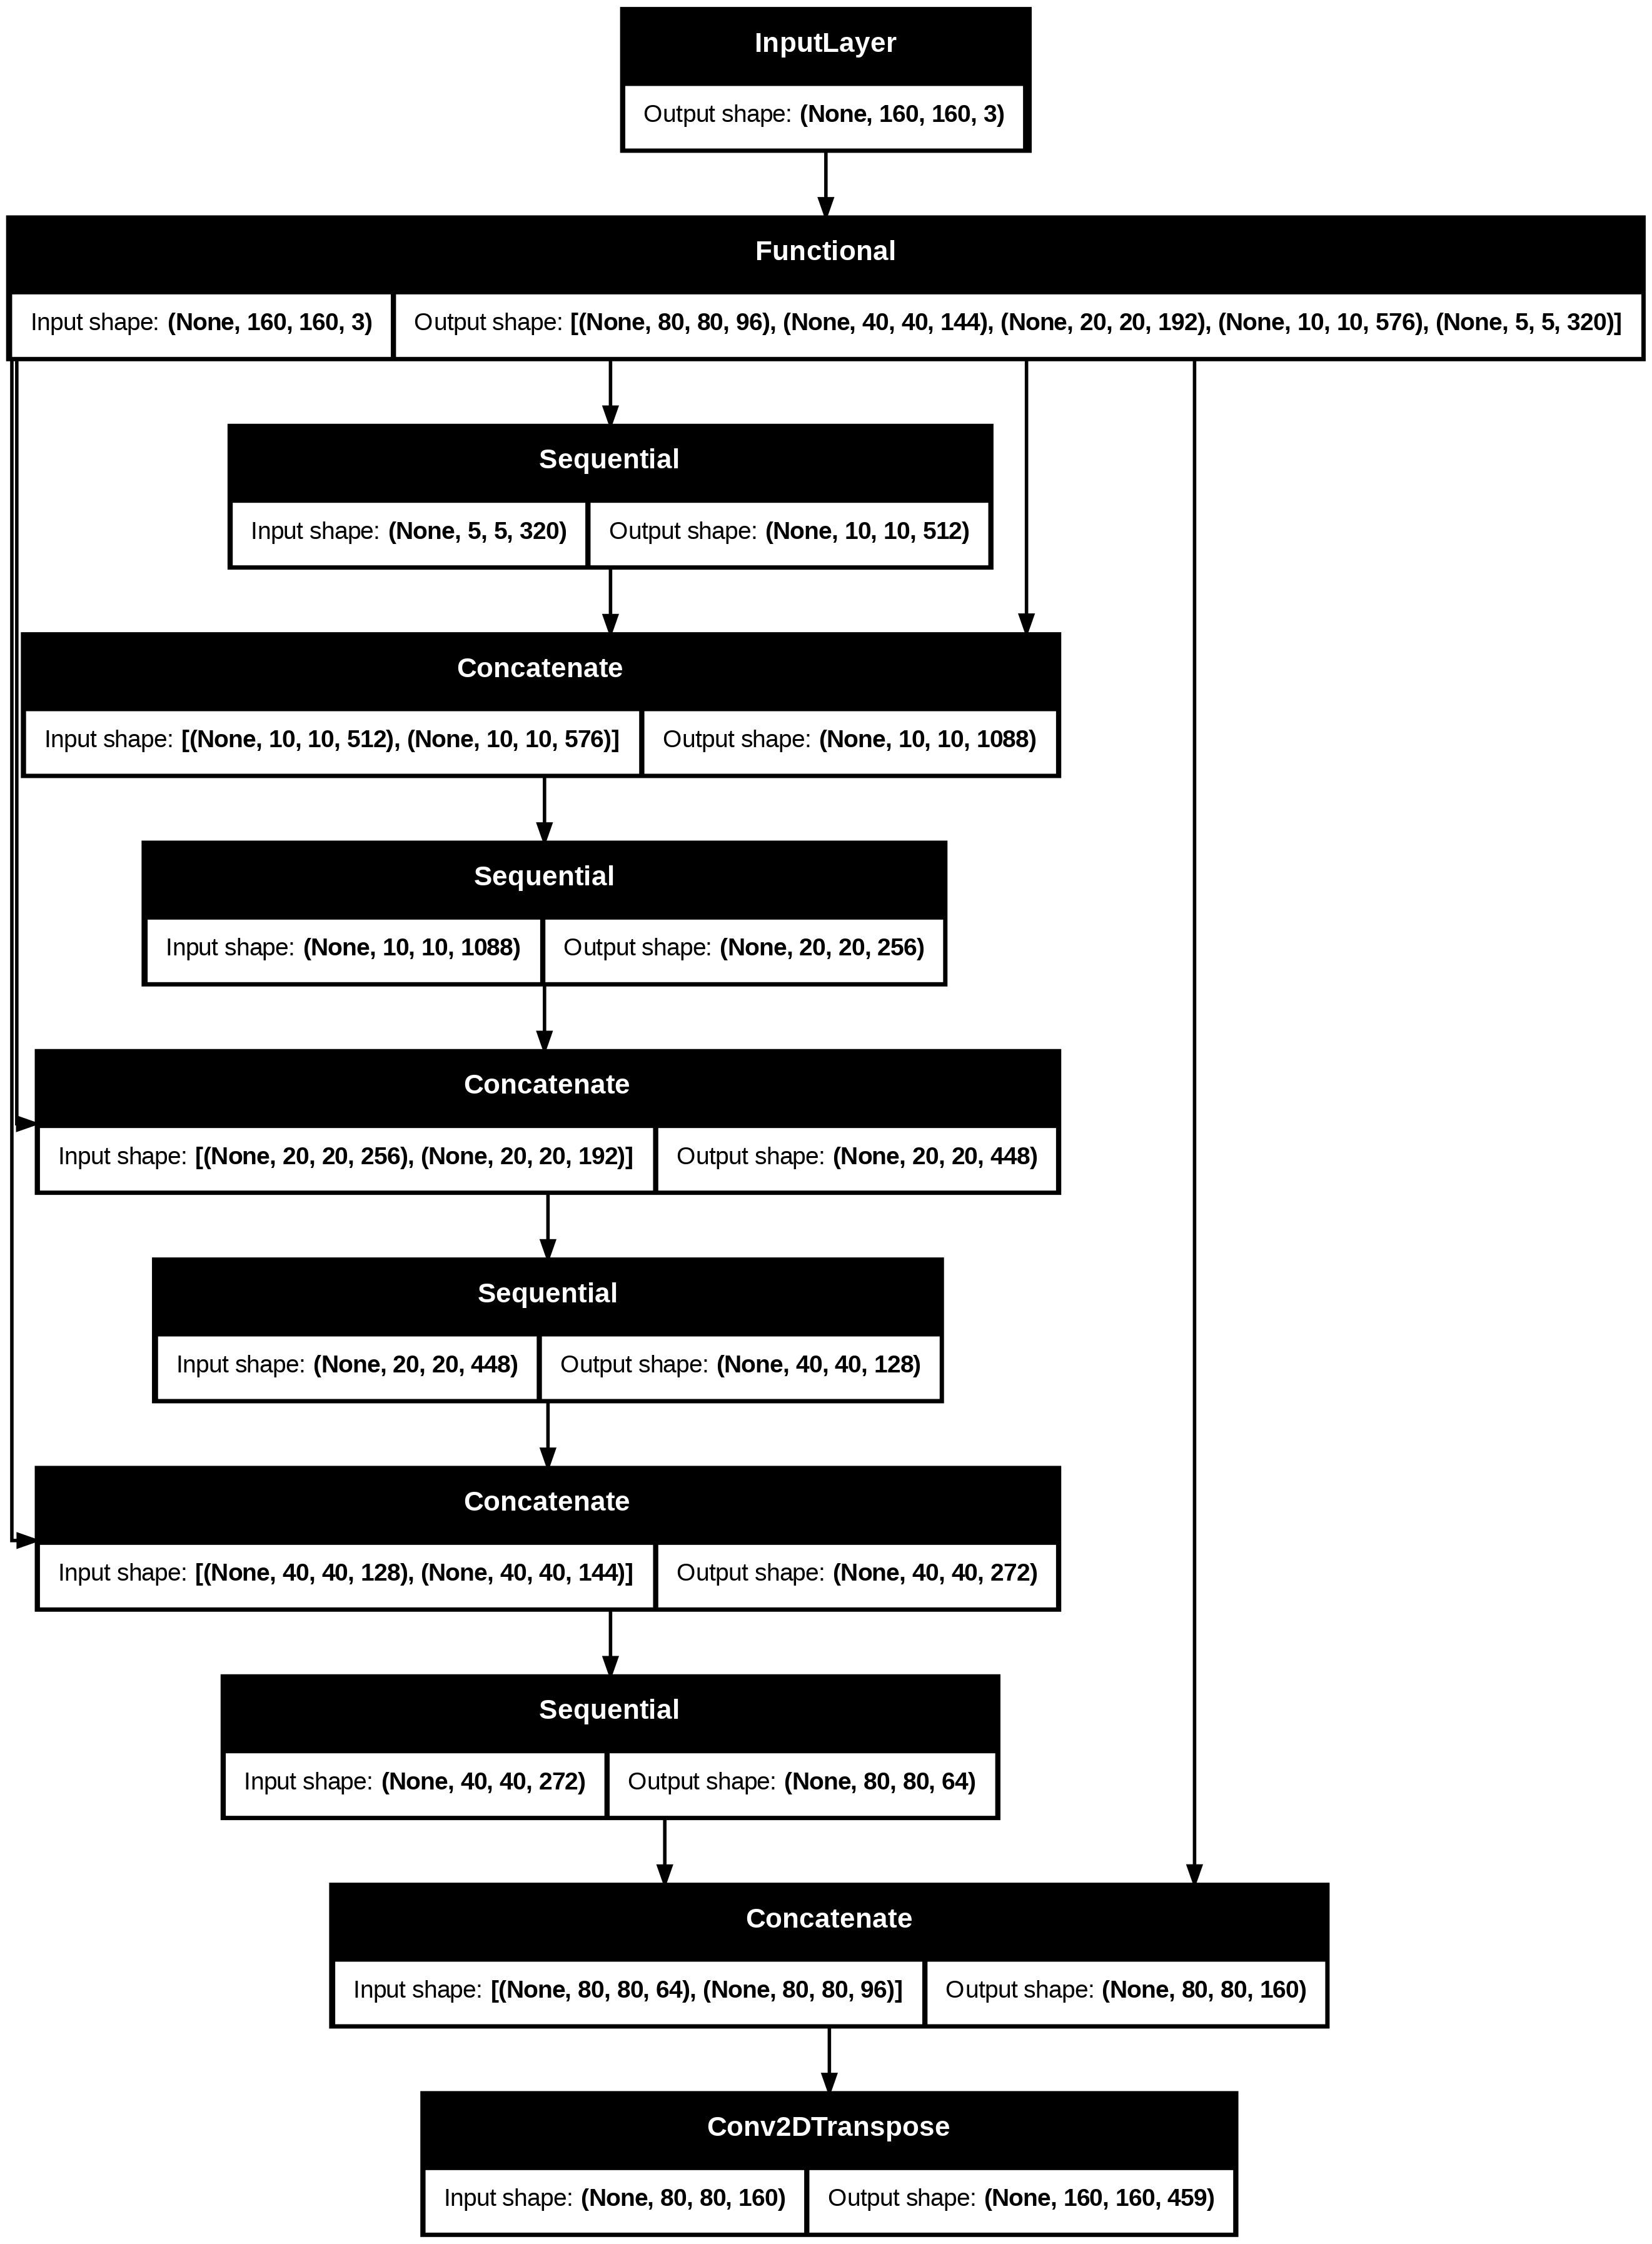

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Training

In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_size // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset)

Epoch 1/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 134s 545ms/step - accuracy: 0.0885 - loss: 4.8473 - val_accuracy: 0.2787 - val_loss: 3.3867
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 114s 525ms/step - accuracy: 0.3363 - loss: 3.1060 - val_accuracy: 0.4099 - val_loss: 2.7544
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 99s 523ms/step - accuracy: 0.4210 - loss: 2.6515 - val_accuracy: 0.4535 - val_loss: 2.4853
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 99s 523ms/step - accuracy: 0.4620 - loss: 2.3929 - val_accuracy: 0.4841 - val_loss: 2.2902
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 99s 522ms/step - accuracy: 0.4943 - loss: 2.2059 - val_accuracy: 0.5212 - val_loss: 2.0769
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 99s 522ms/step - accuracy: 0.5207 - loss: 2.0517 - val_accuracy: 0.5397 - val_loss: 1.9529
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 99s 522ms/step - accuracy: 0.5385 - loss: 1.9581 - val_accuracy: 0.5536 - val_loss: 1.9093
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 99s 522ms/step - accuracy: 0.5597 - loss:

## Visualization

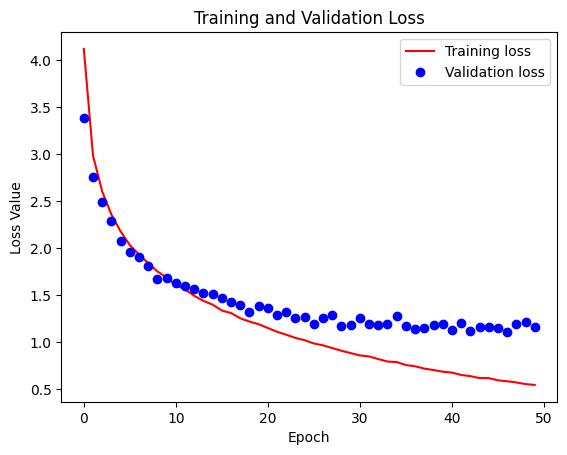

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

# Prediction

In [ ]:
def create_mask(pred_mask):

    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):

    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
def display(display_list):

    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]))
        plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


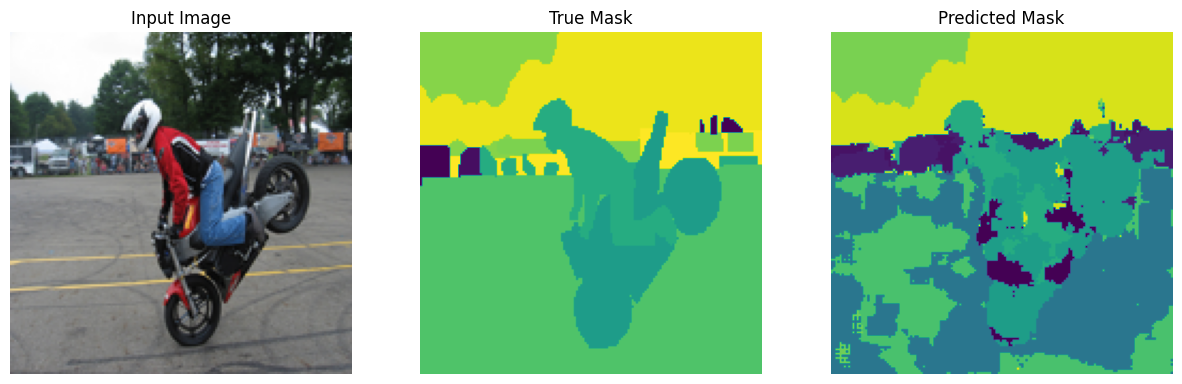

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


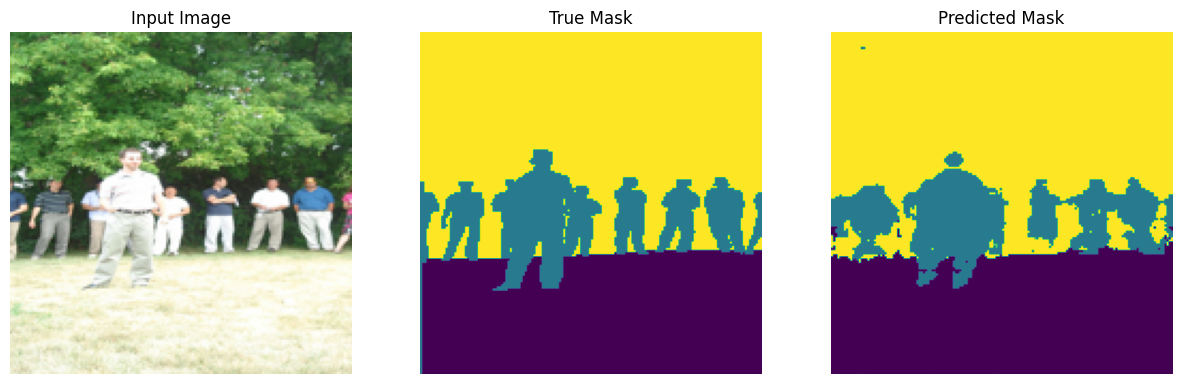

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


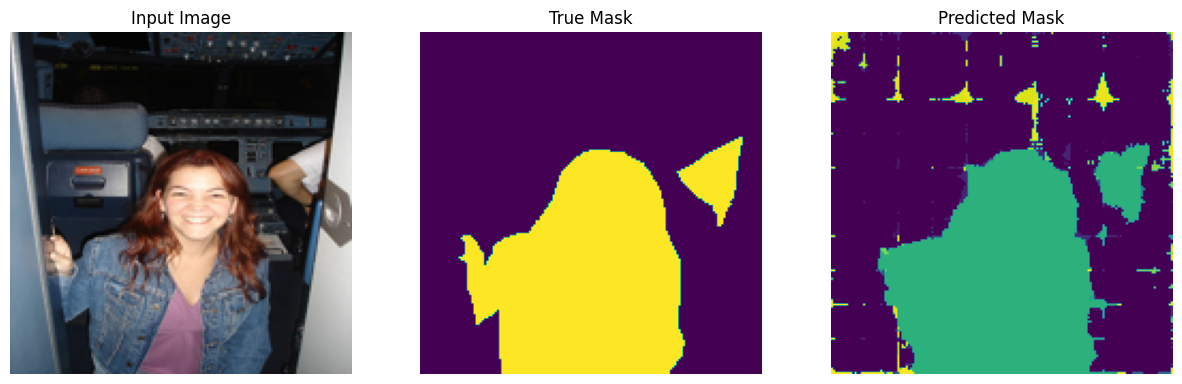

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


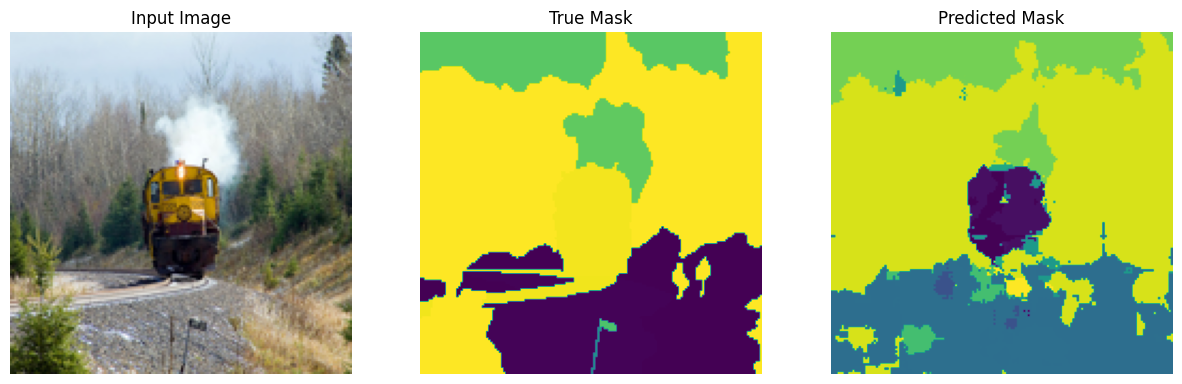

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


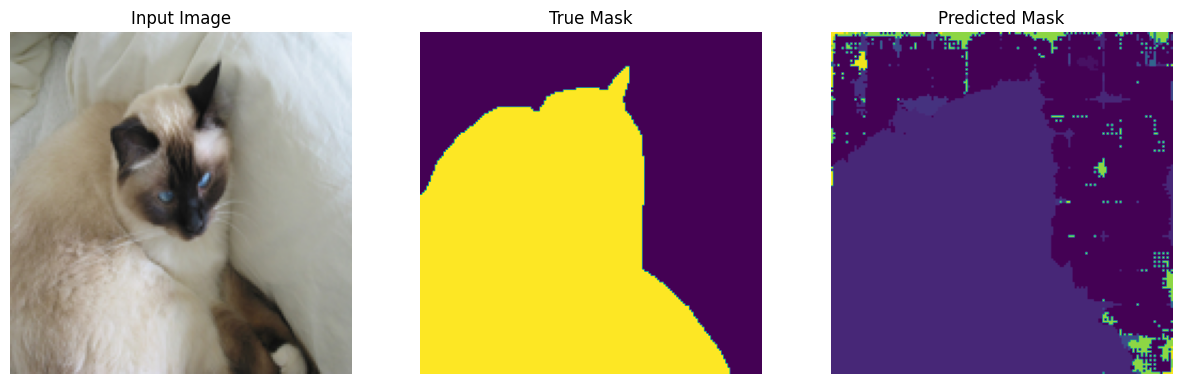

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


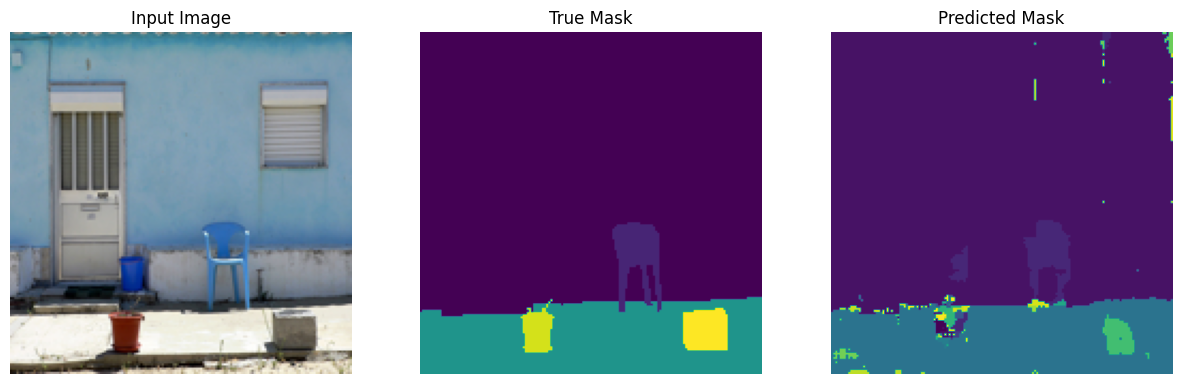

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


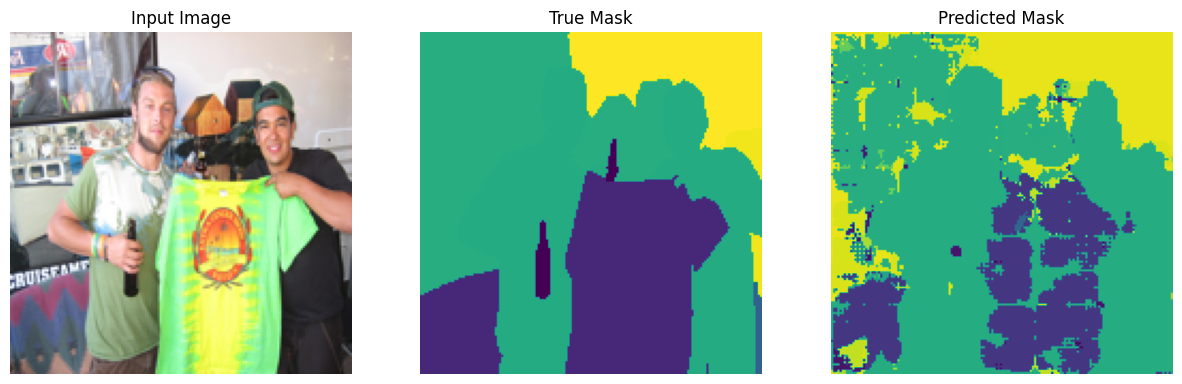

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


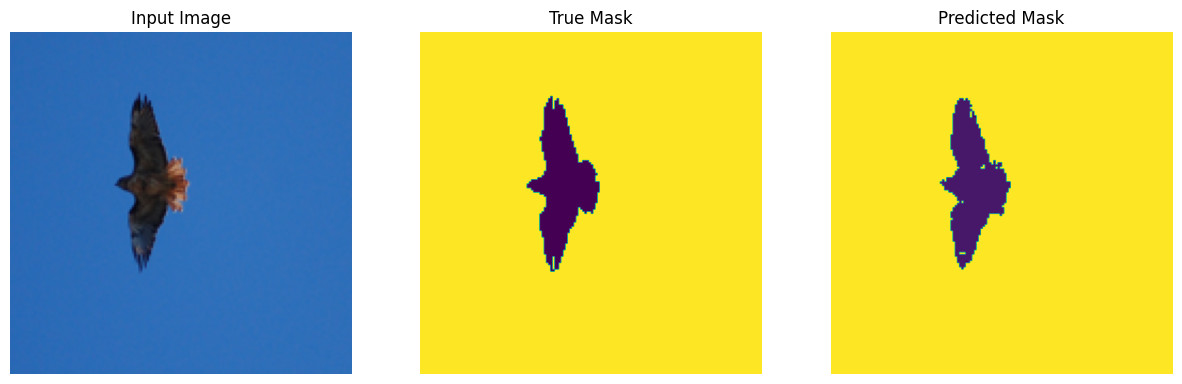

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


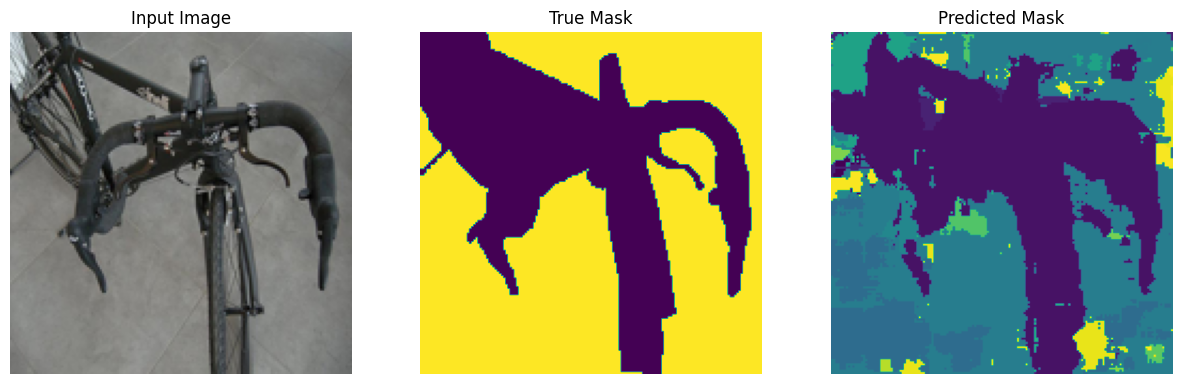

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


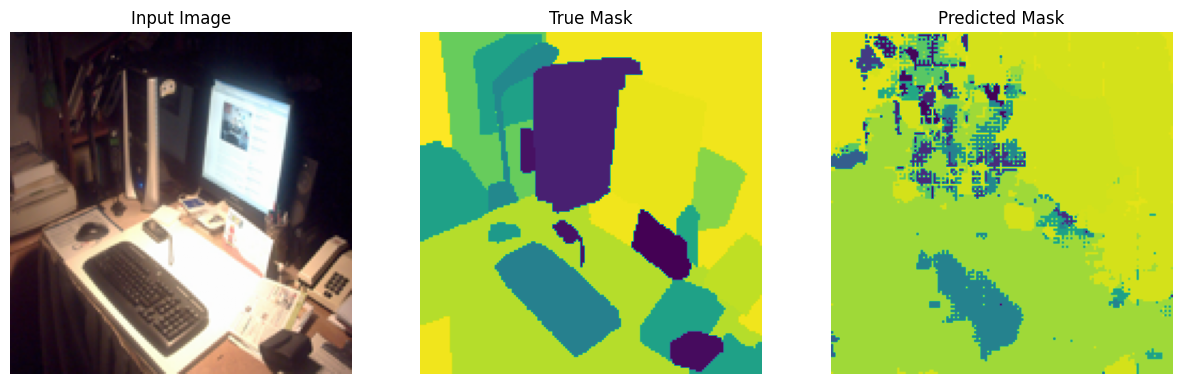

In [ ]:
show_predictions(val_dataset.shuffle(buffer_size=64), num=10)

# Evaluation

In [ ]:
model.evaluate(test_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 437ms/step - accuracy: 0.7440 - loss: 1.2078


[1.1896135807037354, 0.7471323609352112]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


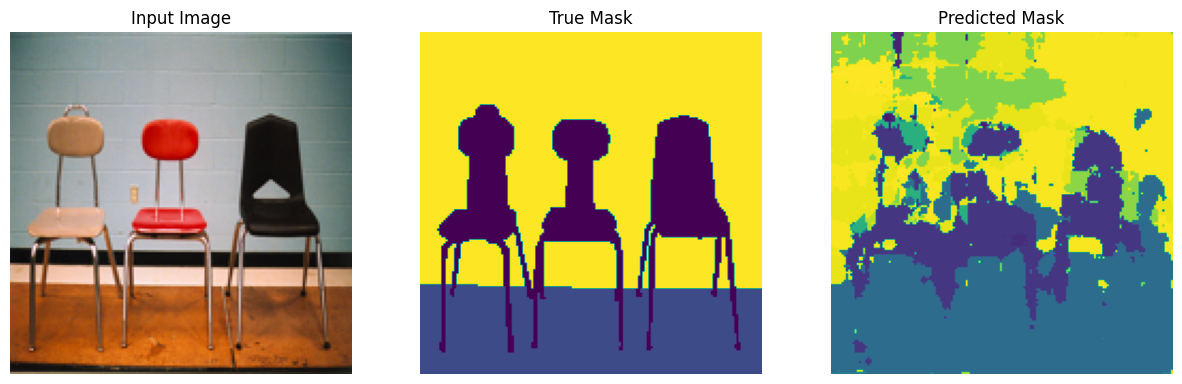

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


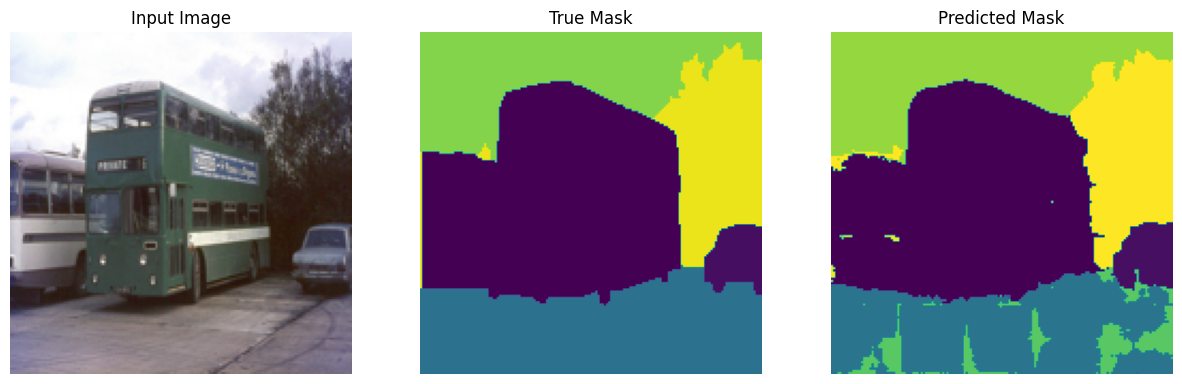

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


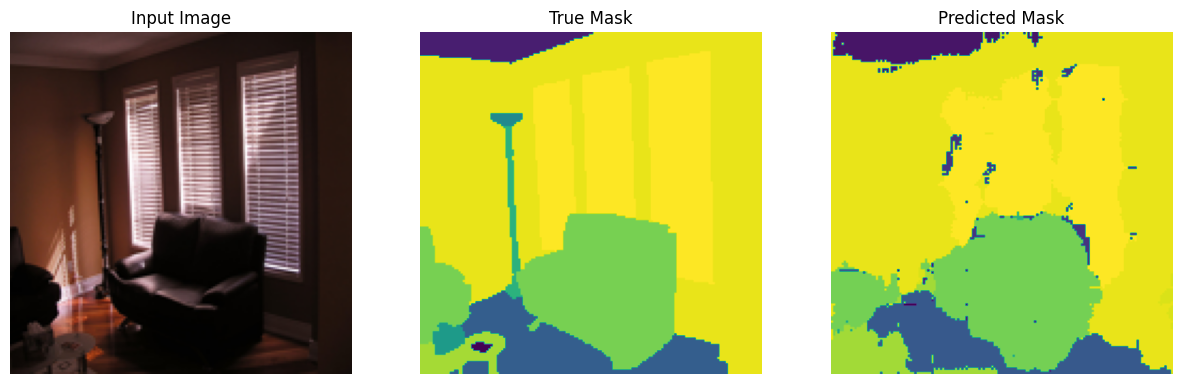

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


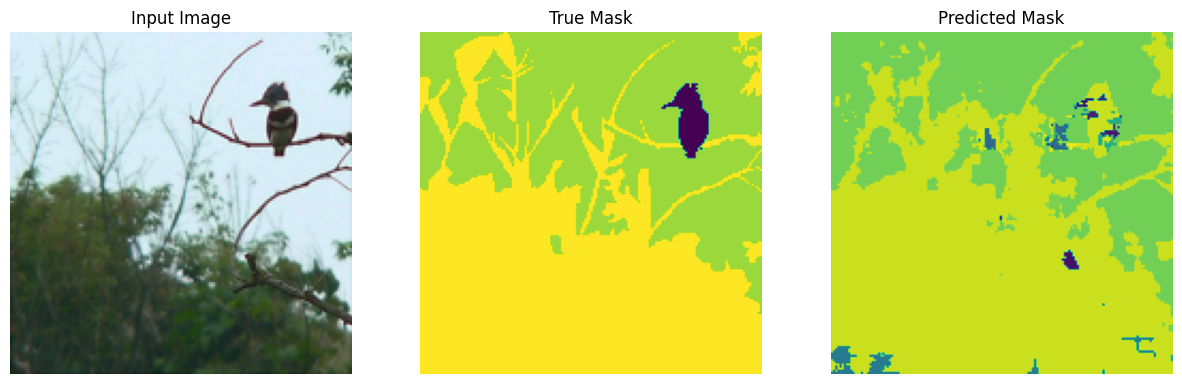

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


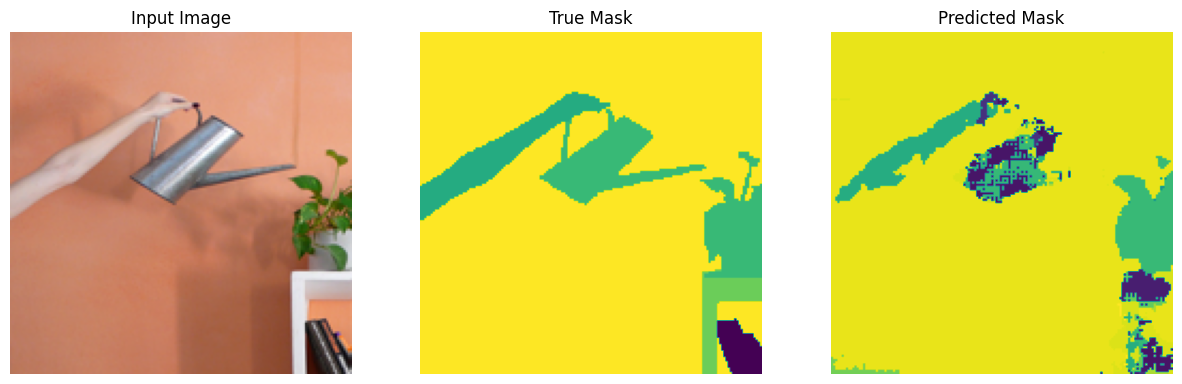

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


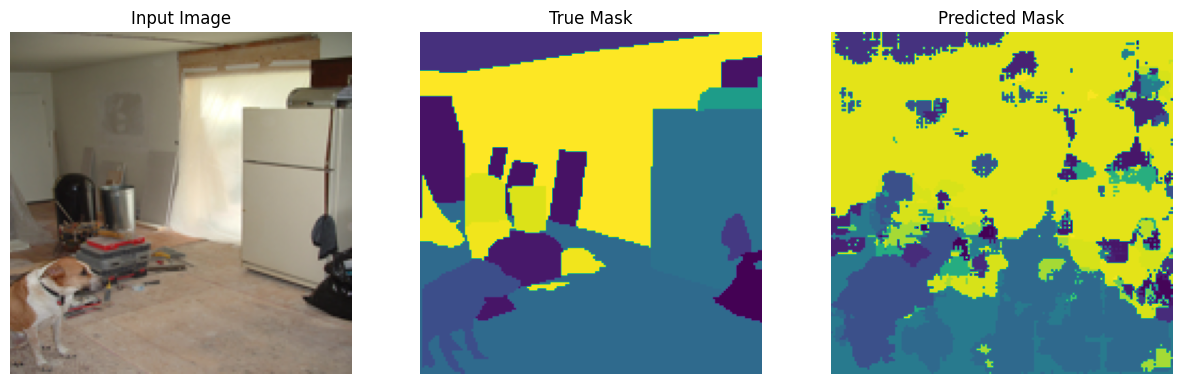

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


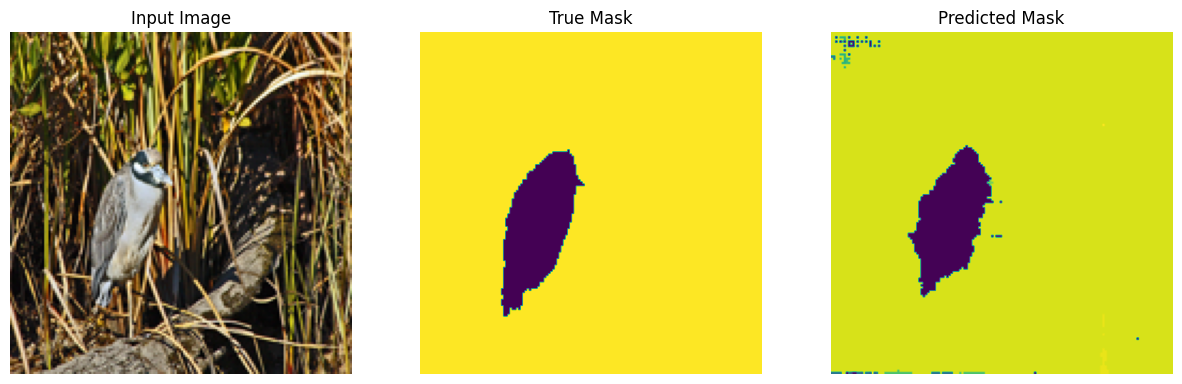

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


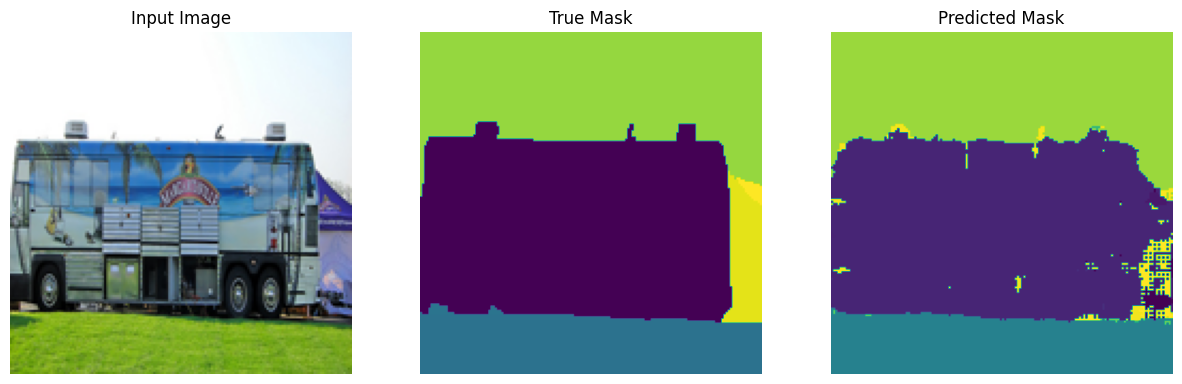

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


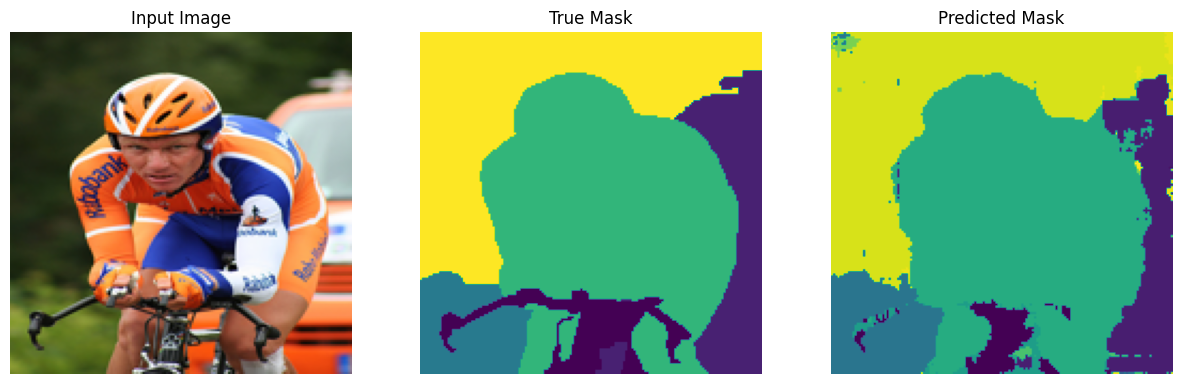

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


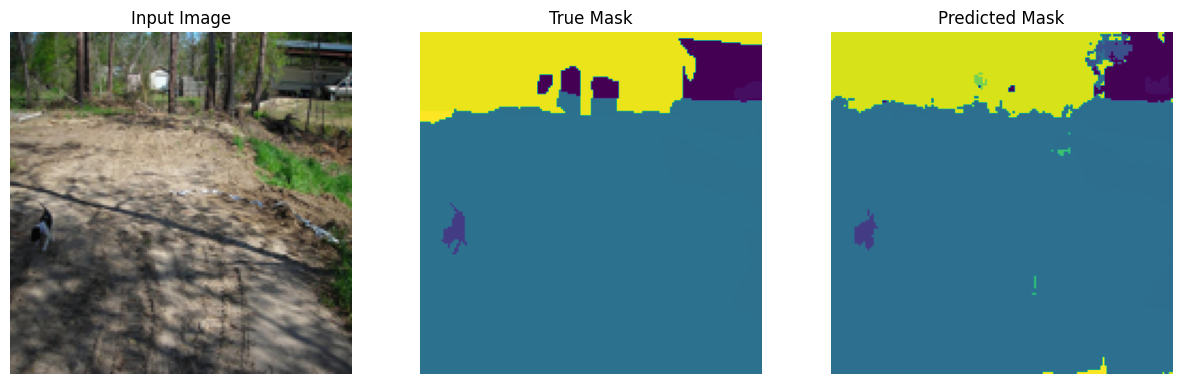

In [ ]:
for image, mask in test_dataset.take(10):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)

    display([image[0], mask[0], pred_mask])